# Местоположение нефтяной скважины

**Исходные данные:** 
синтетические данные с пробами нефти и характеристиками скважин по трем регионам


**Цель:**
построить модель линейной регрессии для определения наиболее прибыльного по добыче региона, проанализировать возможну прибыль и риски с помщью Bootstrap 



**Этапы исследования:**

1.   Загрузка исходных данных и их общая оценка, построение гистрограмм для каждого столбца с числовыми значениями
2. Обучение и проверка модели для каждого региона (разделение датасета 75:25, метрика RMSE)
3. Подготовка данных к расчету прибыли. Расчет объема сырья для безубыточной разработки скважины.
4. Расчет прибыли по скважинам с максимальными значениями предсказаний:
    * Суммировать целевое значение объёма сырья, соответствующее этим предсказаниям
    * Рассчитайть прибыль для полученного объёма сырья.
Посчитайть риски и прибыль для каждого региона:
    * Применить технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
    * Найти среднюю прибыль, 95%-й доверительный интервал и риск убытков

5. Заключение


## 1 Загрузка исходных данных

In [ ]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import scipy.stats as st

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline, make_pipeline

RANDOM_STATE = 42

In [ ]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
  df_0 = pd.read_csv("/content/drive/MyDrive/Yandex/geo_data_0.csv")
  df_1 = pd.read_csv("/content/drive/MyDrive/Yandex/geo_data_1.csv")
  df_2 = pd.read_csv("/content/drive/MyDrive/Yandex/geo_data_2.csv")
except:
  df_0 = pd.read_csv("/datasets/geo_data_0.csv")
  df_1 = pd.read_csv("/datasets/geo_data_1.csv")
  df_2 = pd.read_csv("/datasets/geo_data_2.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# function for primary analysis of data with non-normal distribution
# Kendall correlation
def df_info(df):
    # numeric and non-numeric for histograms and statistic info
    df_num = df.select_dtypes("number")
    df_no_num = df.select_dtypes(exclude="number")
    # the columns number
    length = len(df.columns)
    # correlation method for heatmap
    meth_corr = "kendall"
    # how to split the statistic info for numeric columns
    split_show = 8
    # display 2 digits after the decimal point

    # change labels of columns
    df.columns = (df.columns
                  .str.replace('(?<=[a-z])(?=[A-Z])', '_', regex=True)
                  .str.lower())
    try:
        for name in df.select_dtypes("number").columns:
            df[name] = pd.to_numeric(df[name], downcast="integer" 
                                    if df[name].dtype == "int" else "float")
    finally:
        print("The type left the same as before")


    print('\033[94m  \033[1m {:^24s}'.format("General information"))
    info_0 = pd.DataFrame(df.dtypes.value_counts(), columns=[""])
    info_0.loc["columns", ""] = length
    info_0.loc["row", ""] = len(df)
    info_0.loc["memory_usage, MB", ""] = df.memory_usage().sum() / (1024 ** 2)
    display(info_0)
    print()
    print()

    print('\033[94m  \033[1m {:^24s}'.format("Deep information"))
    info_1 = pd.DataFrame(index=df.columns, columns=['rows'], data=len(df))
    for col in df:
        if (pd.api.types.is_numeric_dtype(df[col])) and df[col].min() == 0:
            info_1.loc[col, "null_row"] = df.loc[df[col] == 0, col].count()
        else:
            info_1.loc[col, "null_row"] = 0
    info_1["uniq"] = df.nunique()
    info_1["dup_val"] = [df[i].duplicated().sum() for i in df]
    info_1["dup_row"] = df.duplicated().sum()
    info_1["NaN"] = df.isna().sum()
    info_1["NaN,%"] = df.isna().sum() / 100
    info_1["type"] = df.dtypes
    info_1 = info_1.join(df.describe(include="number")["mean":].transpose())
    info_1["null_row"] = pd.to_numeric(info_1["null_row"], downcast="integer")
    info_1.fillna("", inplace=True)        
    prop = {
        "border": "0.5px solid black", 
        "width": "85px", 
        "text-align": "center"   
    }
    percent = {
        "NaN,%":"{:.2%}",
        "mean":"{:.3}",
        "std":"{:.3}",	
        "min":"{:.3}",	
        "25%":"{:.3}",	
        "50%":"{:.3}",	
        "75%":"{:.3}",	
        "max":"{:.3}",
    }  

    display(info_1.style.format(percent).set_properties(**prop))
    print()
    print()
    
    print('\033[94m  \033[1m {:^24s}'.format(
        "Distribution of data in numeric columns"
        )
    )
    fig = plt.figure(figsize=(12,6))
    sfigs = fig.subfigures(round(length/4), 4)
    for i, axes in enumerate(sfigs.flat):
      try:
        axes.suptitle(df_num.columns[i])
        if len(df.iloc[:,i]) > 0:
          ax_1= axes.subplots(2, 1, sharex=True, 
                              gridspec_kw={"height_ratios": (.15, .85)})
          sns.boxplot(data=df, x=df_num.columns[i], orient="h", ax=ax_1[0])
          sns.histplot(data=df, x=df_num.columns[i], kde=True, ax=ax_1[1])
          plt.xlabel("")
          plt.ylabel("")
      except:
        break
    plt.show()
    print()
    print()

    print('\033[94m  \033[1m {:^24s}'.format(f"Correlation of {meth_corr}"))
    plt.figure(figsize=(length, length))
    sns.heatmap(df.corr(method=meth_corr), annot=True, linewidths=0.3, 
                cmap='coolwarm', square=True)
    plt.show()


The type left the same as before
     General information   


,
float32,4.00000
object,1.00000
columns,5.00000
row,100000.00000
"memory_usage, MB",2.28894




       Deep information    


,rows,null_row,uniq,dup_val,dup_row,NaN,"NaN,%",type,mean,std,min,25%,50%,75%,max
id,100000,0,99990,10,0,0,0.00%,object,,,,,,,
f0,100000,0,99885,115,0,0,0.00%,float32,0.5,0.872,-1.41,-0.0726,0.502,1.07,2.36
f1,100000,0,99878,122,0,0,0.00%,float32,0.25,0.504,-0.848,-0.201,0.25,0.701,1.34
f2,100000,0,99885,115,0,0,0.00%,float32,2.5,3.25,-12.1,0.288,2.52,4.72,16.0
product,100000,1,99730,270,0,0,0.00%,float32,92.5,44.3,0.0,56.5,91.8,1.29e+02,1.85e+02




   Distribution of data in numeric columns


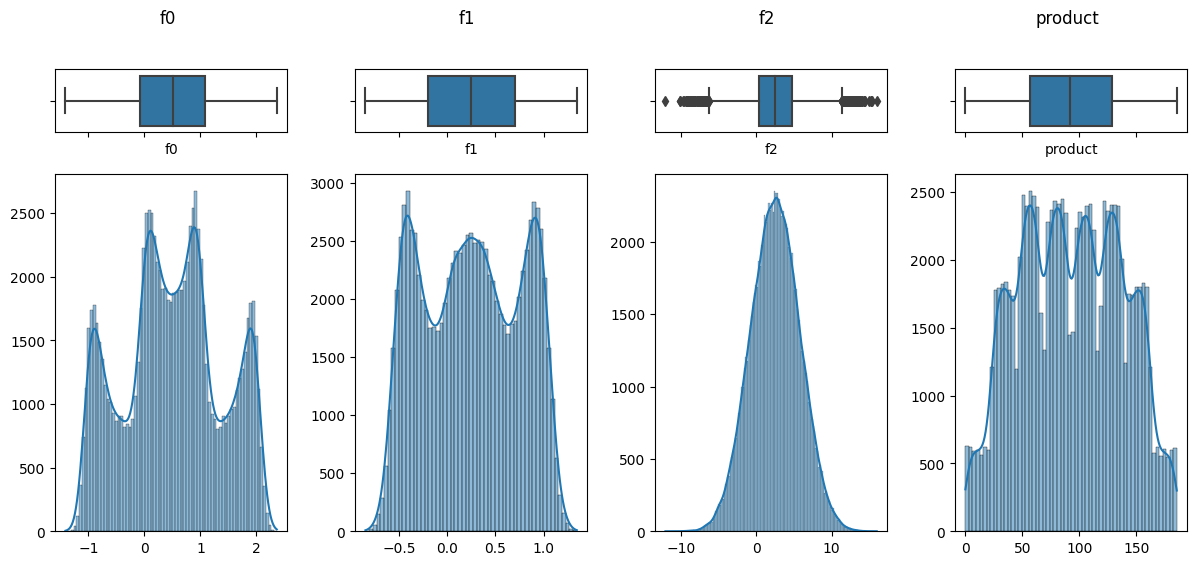



    Correlation of kendall 


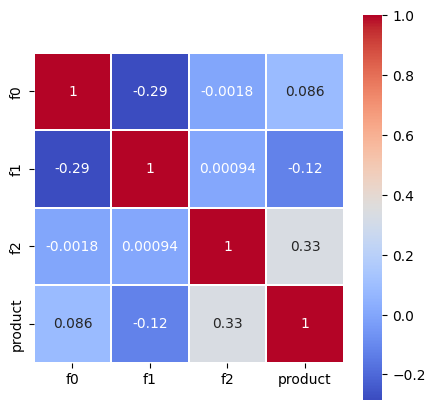

In [ ]:
df_info(df_0)

The type left the same as before
     General information   


,
float32,4.00000
object,1.00000
columns,5.00000
row,100000.00000
"memory_usage, MB",2.28894




       Deep information    


,rows,null_row,uniq,dup_val,dup_row,NaN,"NaN,%",type,mean,std,min,25%,50%,75%,max
id,100000,0,99996,4,0,0,0.00%,object,,,,,,,
f0,100000,0,99902,98,0,0,0.00%,float32,1.14,8.97,-31.6,-6.3,1.15,8.62,29.4
f1,100000,0,99872,128,0,0,0.00%,float32,-4.8,5.12,-26.4,-8.27,-4.81,-1.33,18.7
f2,100000,0,90695,9305,0,0,0.00%,float32,2.49,1.7,-0.0181,1.0,2.01,4.0,5.02
product,100000,8235,12,99988,0,0,0.00%,float32,68.8,45.9,0.0,27.0,57.1,1.08e+02,1.38e+02




   Distribution of data in numeric columns


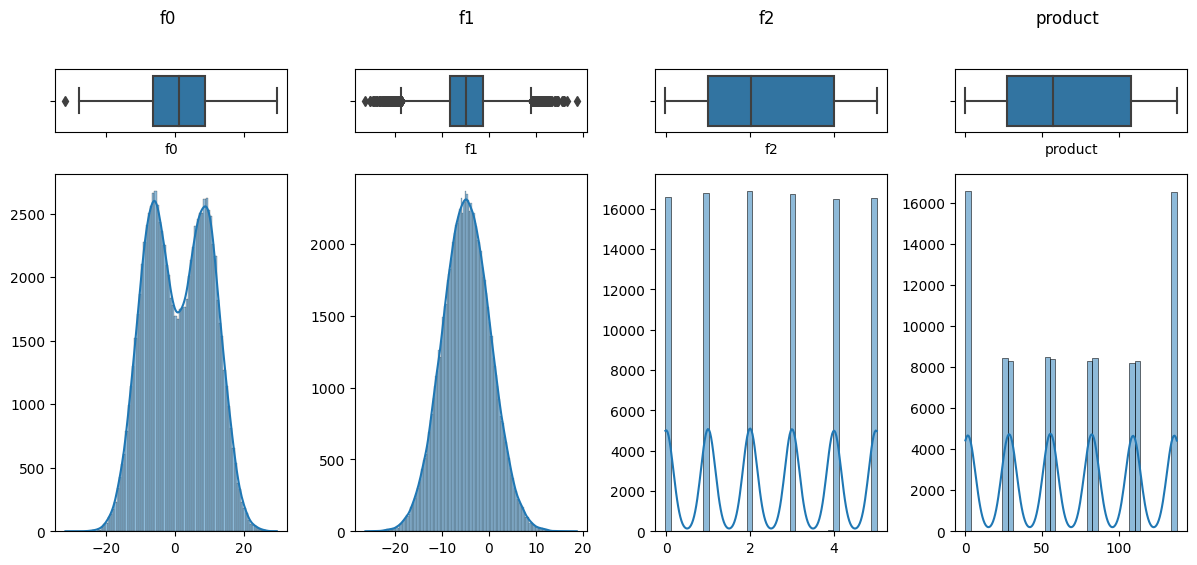



    Correlation of kendall 


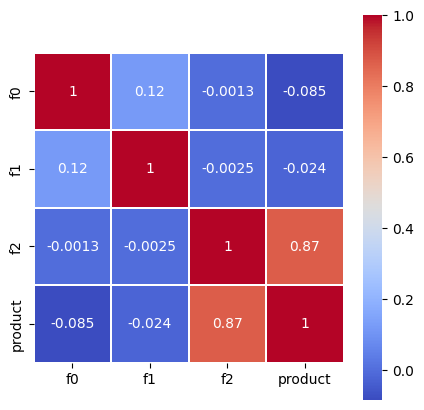

In [ ]:
df_info(df_1)

The type left the same as before
     General information   


,
float32,4.00000
object,1.00000
columns,5.00000
row,100000.00000
"memory_usage, MB",2.28894




       Deep information    


,rows,null_row,uniq,dup_val,dup_row,NaN,"NaN,%",type,mean,std,min,25%,50%,75%,max
id,100000,0,99996,4,0,0,0.00%,object,,,,,,,
f0,100000,0,99922,78,0,0,0.00%,float32,0.00202,1.73,-8.76,-1.16,0.00942,1.16,7.24
f1,100000,0,99944,56,0,0,0.00%,float32,-0.00208,1.73,-7.08,-1.17,-0.00948,1.16,7.84
f2,100000,0,99896,104,0,0,0.00%,float32,2.5,3.47,-12.0,0.13,2.48,4.86,16.7
product,100000,1,99725,275,0,0,0.00%,float32,95.0,44.7,0.0,59.5,94.9,1.31e+02,1.9e+02




   Distribution of data in numeric columns


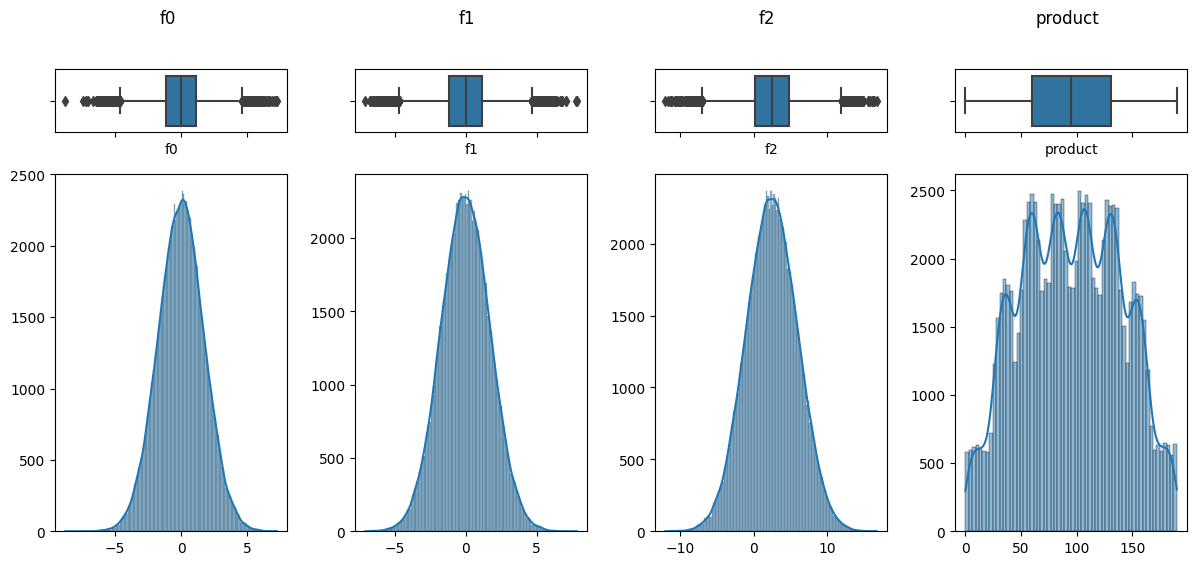



    Correlation of kendall 


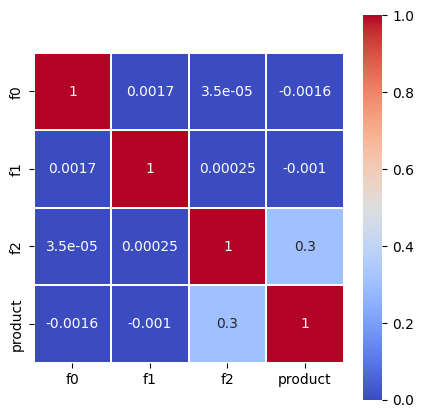

In [ ]:
df_info(df_2)

In [ ]:
df_0[df_0.id.duplicated()]

,id,f0,f1,f2,product
7530,HZww2,1.061194,-0.373969,10.430210,158.828690
41724,bxg6G,-0.823752,0.546319,3.630479,93.007797
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020206
63593,QcMuo,0.635635,-0.473422,0.862670,64.578674
66136,74z30,1.084962,-0.312358,6.990771,127.643326
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
75715,Tdehs,0.112079,0.430296,3.218993,60.964020
90815,fiKDv,0.049883,0.841313,6.394613,137.346588
92341,TtcGQ,0.110711,1.022689,0.911381,101.318008
97785,bsk9y,0.378429,0.005837,0.160827,160.637299


In [ ]:
df_1[df_1.id.duplicated()]

,id,f0,f1,f2,product
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038887
82873,wt4Uk,10.259973,-9.376355,4.994297,134.766312
84461,5ltQ6,18.213839,2.191999,3.993869,107.813042


In [ ]:
df_2[df_2.id.duplicated()]

,id,f0,f1,f2,product
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233414
55967,KUPhW,1.211151,3.176408,5.543540,132.831802
95090,Vcm5J,2.587702,1.986875,2.482245,92.327576


Данные не имеют пропущенных значений и явных дубликатов. Датасеты df_0 и df_1 имет по одному признаку с нормальным распределением, в то время как в df_3 их 3 из 4. Во всех датасетах наблюдаются нулевые значения в столбце product,вариантов заполнения нет. В датасете df_1 довольно много таких значений, поэтому удаление значений нецелесообразно. Между целевым признаком product и f2 во всех датасетах наблюдается корреляция. В данных так же наблюдаются выбросы

## 2 Обучение модели

In [ ]:
# function for the fitting model
def linear_model(df):
    # define stratify train and test data
    X = df.iloc[:, 1:-1]
    y = df.iloc[:, -1]
    X_train, X_test, \
    y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)
    # bild and train
    model = make_pipeline(StandardScaler(), LinearRegression())
    model.fit(X_train, y_train)
    # evalute the model
    prediction = model.predict(X_test)
    rmse = mean_squared_error(y_test, prediction, squared=False)
    r2 = r2_score(y_test, prediction)
    # create dataframe from true values and predictions
    predict_test = pd.DataFrame({
        "predict": prediction, 
        "test": y_test}, 
        index=y_test.index
    )
    return r2, rmse, prediction, y_test, predict_test


In [ ]:
len(y_test_0)

25000

In [ ]:
len(predict_test_0)

25000

In [ ]:
# get from the function metrics, predictions, true values and dataframe
r2_0, rmse_0, prediction_0, y_test_0, predict_test_0 = linear_model(df_0)
r2_1, rmse_1, prediction_1, y_test_1, predict_test_1 = linear_model(df_1)
r2_2, rmse_2, prediction_2, y_test_2, predict_test_2 = linear_model(df_2)

In [ ]:
# display results for region 0
print(f"""Error rate:{r2_0: .2f} 
RMSE: {rmse_0:.2f}
Mean of predicted oil production: \
{prediction_0.mean():.2f} thousand barrels
Mean of real oil production: \
{y_test_0.mean():.2f} thousand barrels""")

Error rate: 0.27 
RMSE: 37.76
Mean of predicted oil production: 92.40 thousand barrels
Mean of real oil production: 92.33 thousand barrels


In [ ]:
# display results for region 1
print(f"""Error rate:{r2_1: .2f} 
RMSE: {rmse_1:.2f}
Mean of predicted oil production: \
{prediction_1.mean():.2f} thousand barrels
Mean of real oil production: \
{y_test_1.mean():.2f} thousand barrels""")

Error rate: 1.00 
RMSE: 0.89
Mean of predicted oil production: 68.71 thousand barrels
Mean of real oil production: 68.73 thousand barrels


In [ ]:
# display results for region 2
print(f"""Error rate:{r2_2: .2f} 
RMSE: {rmse_2:.2f}
Mean of predicted oil production: \
{prediction_2.mean():.2f} thousand barrels
Mean of real oil production: \
{y_test_2.mean():.2f} thousand barrels""")

Error rate: 0.20 
RMSE: 40.15
Mean of predicted oil production: 94.77 thousand barrels
Mean of real oil production: 95.15 thousand barrels


### Вывод
Обученнная модель линейной регрессии показала наилучшее качество, исходя из метрики `r2`, в регионе 1 и там же предсказал наименьшее среднее количество запасов сырья. Тем не менее, эти данные совпали с действительным средним. Но наибольшие запасы сырья содержатся в регионах 0 и 3, где качество модели оставляет желать лучшего.

## 3 Расчет безубыточного объема сырья

In [ ]:
# save all bissnes parameters 
ALL_STATIONS = 500 # research stations
BEST_STATIONS = 200 # choose the best stations
DEVELOP_BUDGET = 10**10 # how much money for developing
INCOME = 450 * 1000 # price per 1000 barrels
LOSS = 0.025 # level of the loss for the region

In [ ]:
# look at the break-even volume and compare with the real volume
print(f'''Break-even production volume:\
{DEVELOP_BUDGET / BEST_STATIONS / INCOME: .0f} thousand barrels''')
for i, test in enumerate([y_test_0, y_test_1, y_test_2]):
    print(f"""Mean of real oil production in {i} region: \
{test.mean():.2f} thousand barrels""")

Break-even production volume: 111 thousand barrels
Mean of real oil production in 0 region: 92.33 thousand barrels
Mean of real oil production in 1 region: 68.73 thousand barrels
Mean of real oil production in 2 region: 95.15 thousand barrels


### Вывод
Ни один из регионов не превысил планку безубыточности. Более близком к этому регион 0, опережая на несколько десятых регион 2

## 4 Расчет прибыли

In [ ]:
def revenue(data):
    # calculates the revenue of the top stations
    top_stations = data.sort_values(by="predict", 
                                    ascending=False)[:BEST_STATIONS]
    return top_stations["test"].sum() * INCOME - DEVELOP_BUDGET


In [ ]:
# display the number of profit for each datasets 
for i, name in enumerate([predict_test_0, predict_test_1, predict_test_2]):
    print(f"""Profit in {i} region for the received volume of raw materials \
{revenue(name) / 10**9:,.2f} billions rubles""")

Profit in 0 region for the received volume of raw materials 3.36 billions rubles
Profit in 1 region for the received volume of raw materials 2.42 billions rubles
Profit in 2 region for the received volume of raw materials 2.60 billions rubles


In [ ]:
def distribution(data_pt, number, iterator=1000):
        
    # create an empty list to store the revenue values
    values = []

    # iterate 1000 times to simulate different samples and calculate revenue
    for i in range(iterator):
        # sample with replacement to simulate different stations being selected each time
        sample_test = data_pt.sample(
            n=ALL_STATIONS, replace=True, random_state=state)
        # calculate the revenue for this sample and add it to the list
        values.append(revenue(sample_test))

    # convert the list to a pandas Series for easier analysis and plotting
    distrube_revenue = pd.Series(values)
    # calculate the probability of loss (revenue < 0)
    loss_percent = (distrube_revenue < 0).mean()
    # plot a histogram of the revenue values
    sns.histplot(data=distrube_revenue, kde=True)
    # add a vertical line for the mean revenue
    plt.axvline(distrube_revenue.mean(), color='r', linestyle='--')
    # add a title and axis labels to the plot
    plt.title(f"Distribution of the all revenues in region {number}")
    plt.xlabel("Revenue")
    plt.show()
    # print the probability of loss and the range of the 95% confidence interval for the mean revenue
    print_loss = f"Probabillity of loss in region {number} is {loss_percent:.2%}"
    print_interval = f"""There is a 95% probability that the average profit \n
    value will fall within the range of \n 
    {distrube_revenue.quantile(0.025) / 10**6:,.2f} millions rubles to \n
    {distrube_revenue.quantile(0.975) / 10**6:,.2f} millions rubles"""
    print(print_loss, print_interval, sep="\n")


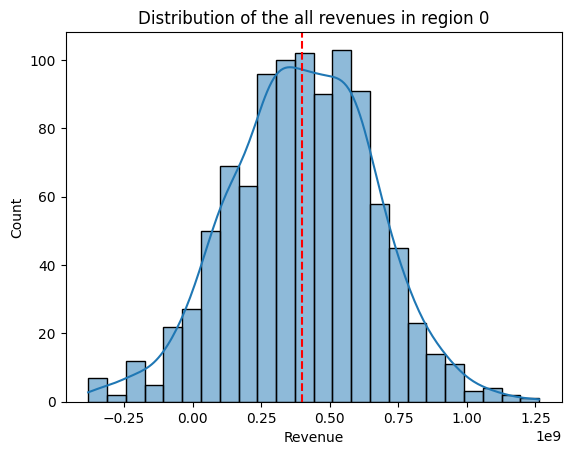

Probabillity of loss in region 0 is 6.00%
There is a 95% probability that the average profit 

    value will fall within the range of 
 
    -110.47 millions rubles to 

    897.46 millions rubles


In [ ]:
distribution(predict_test_0, 0)


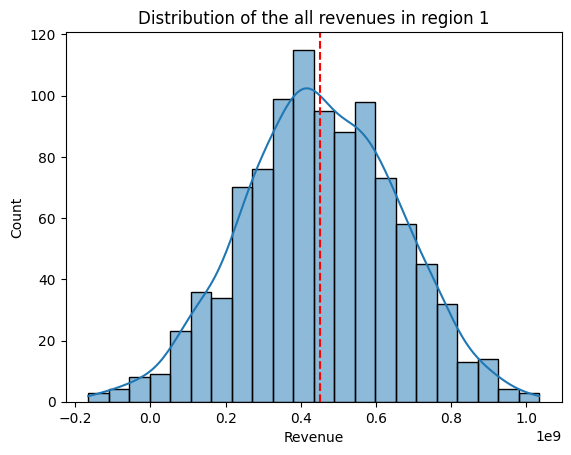

Probabillity of loss in region 1 is 1.50%
There is a 95% probability that the average profit 

    value will fall within the range of 
 
    61.68 millions rubles to 

    845.34 millions rubles


In [ ]:
distribution(predict_test_1, 1)


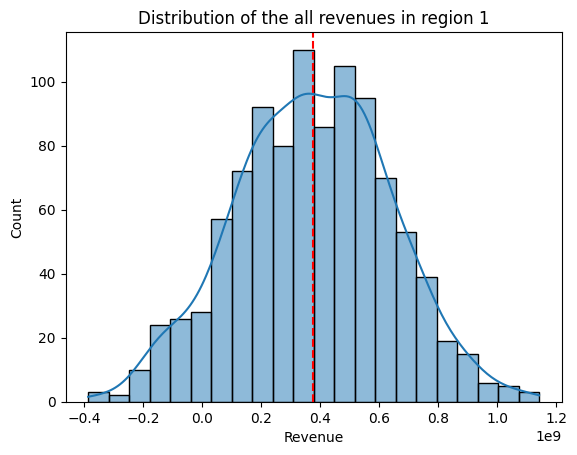

Probabillity of loss in region 1 is 8.00%
There is a 95% probability that the average profit 

    value will fall within the range of 
 
    -14.48 millions rubles to 

    88.84 millions rubles


In [ ]:
distribution(predict_test_2, 1)


### Вывод 
Наименьшие потери, которые составляют 1.5%, в регионе 1. Там же распределение значений прибыли наиболее плотное. Перспективные регионы показали уровень потерь больший, чем регион 0 и более широкое распределение значений прибыли.

## 5 Заключение

В регионе 0 вероятность убытков составляет 6%, а в регионе 1 и 2 - 1.5% и 8% соответственно. Это означает, что наиболее рискованным является второй регион.

Однако, при этом во всех регионах прогнозируемые средние значения прибыли с вероятностью 95% могут быть от -110 до 897 млн. рублей.

Точка безубыточности составляет 111 тыс. баррелей. Реальное среднее производство нефти в регионах 0, 1 и 2 составляет соответственно 92.33 тыс. баррелей, 68.73 тыс. баррелей и 95.15 тыс. баррелей.

Оценка качества модели прогнозирования показала, что в регионе 0 и 2 модели дают прогнозы с неплохой точностью, хотя RMSE достаточно высокий. В регионе 1 модель дает более точные прогнозы, но ошибка прогноза немного выше.

На основе всех этих данных можно рекомендовать бизнесу сконцентрироваться на развитии добычи нефти в регионе 1, где вероятность убытков самая низкая и модель прогнозирования дает более точные прогнозы производства. Однако, бизнес также может рассмотреть возможность развития в регионах 0 и 2, если риски могут быть управляемыми и потенциальная прибыль будет достаточно высокой.